## skipgram

In [1]:
import string
# read in data, remove punctuation and make all lower case
def read_words(filename):
    words = []
    translator = str.maketrans('', '', string.punctuation)
    scount = 0
    with open(filename) as f:
        for s in f:
            scount += 1
            clean_s = s.translate(translator).lower()
            words.append(clean_s.split())
    return words
        

In [2]:
# create dict that returns the index of onehot encoding for a word (and other way around)
# also create a frequency dict + set size, usuable for negative sampling
import numpy as np

def get_onehot_dicts(corpus):
    # create one set of all unique words
    flat_corpus = [w for s in corpus for w in s]
    corpus_set = set(flat_corpus)
    w_to_i = {}
    i_to_w = {}
    w_freq = []
    num_words = len(corpus_set)
    for i, w in enumerate(corpus_set):
        w_to_i[w] = i
        i_to_w[i] = w
        freq = flat_corpus.count(w)**0.75
        w_freq.append([i, freq])
    return w_to_i, i_to_w, np.array(w_freq), num_words

In [3]:
#corpus = read_words('wa/test.en')
corpus = read_words('hansards/training.en')
print('corpus created')
w_to_i, i_to_w, w_freq, num_words = get_onehot_dicts(corpus)

corpus created


In [4]:
# create all positive samples
import torch
def get_pos_pairs(corpus, window_size):
    pairs = [] 
    for s in corpus:
        for i, word in enumerate(s):
            word_index = w_to_i[word]
            for j in range(i-window_size, i+window_size+1):
                if j < 0 or j >= len(s) or j == i:
                    continue
                context = s[j]
                context_index = w_to_i[context]
                pairs.append([word_index, context_index])
    return torch.LongTensor(pairs)

In [5]:
pairs = get_pos_pairs(corpus, 5)

In [6]:
from torch.utils.data import sampler
# get negative samples for a single batch
def get_neg_pairs_batch(num_samples, w_freq, pos_batch):
    batch_size = len(pos_batch)
    start_neg = time.time()
    total = w_freq[:,1].sum()
    prob = [freq/total for freq in w_freq[:, 1]]
    
    neg_sampler = sampler.WeightedRandomSampler(prob, batch_size*num_samples)
    neg_contexts_list = list(sampler.BatchSampler(neg_sampler, num_samples, drop_last=False))
#     neg_contexts_list = []
#     for pos_pair in pos_batch:
#         word = pos_pair[0].item()
#         # get negative context words based on their frequencies
#         neg_contexts = np.random.choice(w_freq[:,0], p=prob, size=num_samples) 
#         neg_contexts_list.append(neg_contexts)
    return torch.LongTensor(neg_contexts_list)

In [7]:
# get negative pairs for all positives in a dict
def get_neg_pairs(num_samples, w_freq, pos_pairs):
    neg_dict = {} # pos-pair : neg-pairs
    total = w_freq[:,1].sum()
    prob = [freq/total for freq in w_freq[:, 1]]
    for pair in pos_pairs:
        word = pair[0].item()
        # get negative context words based on their frequencies
        neg_contexts = np.random.choice(w_freq[:,0], p=prob, size=num_samples) 
        neg_dict[tuple(pair.numpy())] = torch.LongTensor(neg_contexts)
    return neg_dict

In [8]:
import torch.nn as nn
class skipgram(nn.Module):
    def __init__(self, vocab_size, emb_dimension):
        super(skipgram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dimension = emb_dimension
        # start with random embeddings
#         self.W_embeddings = torch.randn((vocab_size, emb_dimension), requires_grad=True)
#         self.C_embeddings = torch.randn((vocab_size, emb_dimension), requires_grad=True)
        self.W_embeddings = nn.Embedding(vocab_size, emb_dimension)
        self.C_embeddings = nn.Embedding(vocab_size, emb_dimension)
        
    def forward(self, word, pos_context, neg_contexts):
        # word, pos_context and neg_contexts are integers, so can just pick that row from W and C matrices
        word_embed = self.W_embeddings(word)
        pos_embed = self.C_embeddings(pos_context)
        neg_embeds = self.C_embeddings(neg_contexts)
        
        pos_similarity = torch.mul(word_embed, pos_embed).squeeze()
        pos_sum = torch.sum(pos_similarity, dim=1)
        pos_logsig = nn.functional.logsigmoid(pos_sum)
        pos_score = sum(pos_logsig)
        
        neg_similarity = torch.bmm(neg_embeds, word_embed.unsqueeze(2)).squeeze()
        neg_sum = torch.sum(neg_similarity, dim=1)
        neg_logsig = nn.functional.logsigmoid(-1 * neg_sum)
        neg_score = sum(neg_logsig)
        
        loss = -(pos_score+neg_score)
        
        return loss
        

In [9]:
print(len(pairs))

28341486


1058.7734375
1.8331403732299805
282.65283203125
599.6580777168274
312.9863586425781
586.4055223464966
149.19137573242188
617.715133190155
121.67973327636719
619.2836768627167
120.29609680175781
617.9573712348938
91.77223205566406
613.4333052635193
130.14755249023438
617.5550625324249
98.15018463134766
624.1881077289581
76.92536163330078
619.4178555011749
155.11410522460938
616.331827878952
96.92939758300781
616.5400629043579
86.76530456542969
617.3500626087189
51.3530387878418
617.243780374527
61.97071075439453
617.8191766738892
89.54547882080078
617.5512547492981
75.5953598022461
616.5203673839569
73.55732727050781
615.9626379013062
67.22058868408203
617.1685492992401
58.05543518066406
617.5852768421173
94.72454833984375
617.3524491786957
70.27543640136719
617.2970552444458
91.14883422851562
618.0375015735626
total time taken: 13958.177823781967


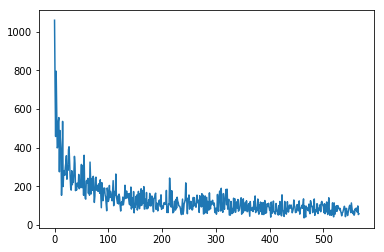

In [22]:
# train skipgram
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

start_time = time.time()

dataloader = DataLoader(pairs, batch_size=50, shuffle=True)
use_cuda = torch.cuda.is_available()

sg_model = skipgram(num_words, 300)
if use_cuda:
    sg_model.cuda()
optimizer = torch.optim.SGD(sg_model.parameters(), lr=0.01)
sg_model.train()
loss_progress = []
iter_time = time.time()
for i, pos_batch in enumerate(dataloader):
    neg_batch = get_neg_pairs_batch(5, w_freq, pos_batch)
    optimizer.zero_grad()
    if use_cuda:
        loss = sg_model.forward(pos_batch[:, 0].cuda(), pos_batch[:, 1].cuda(), neg_batch.cuda())
    else:
        loss = sg_model.forward(pos_batch[:, 0], pos_batch[:, 1], neg_batch)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        loss_progress.append(loss.item())  
    if i % 25000 == 0:
        print(loss_progress[-1])
        print(time.time()-iter_time)
        iter_time = time.time()


print("total time taken:", time.time()-start_time)
plt.plot(loss_progress)
plt.show()

In [29]:
torch.save(sg_model, 'skipgram.pt')

C:\Users\Manon\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type skipgram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [30]:
sg_model2 = torch.load('skipgram.pt')

In [31]:
for x in sg_model2.parameters():
    print(x)

tensor([[-6.3033e-01, -7.1565e-01,  1.1140e+00,  ...,  1.1596e+00,
          1.2968e+00, -4.3629e-01],
        [-1.8432e+00, -2.3758e-01,  1.1066e+00,  ...,  7.2553e-01,
         -7.6718e-01,  2.3105e-01],
        [-1.8835e-01,  9.2264e-02,  1.3642e+00,  ...,  2.7662e-02,
         -1.4662e+00,  1.6974e-01],
        ...,
        [ 1.3741e+00,  8.0042e-01, -1.3012e+00,  ...,  1.6535e+00,
          1.2936e+00,  1.2253e+00],
        [-6.4729e-01,  2.7872e+00, -2.7748e-01,  ...,  9.8011e-02,
          2.7258e-01, -1.4179e-01],
        [-4.7581e-01,  1.7103e+00, -2.6070e-01,  ..., -1.6745e+00,
          7.3246e-01,  4.9347e-02]], device='cuda:0')
tensor([[-1.2682e+00, -2.7042e-01,  1.5596e+00,  ..., -6.5224e-01,
         -7.1039e-01,  1.0516e+00],
        [-8.6389e-01, -5.7281e-01, -1.0506e+00,  ...,  1.2027e-01,
          1.5466e+00,  1.5740e+00],
        [-5.2023e-02, -1.0060e+00,  1.1503e+00,  ..., -5.7422e-01,
          2.9689e-01,  1.4628e+00],
        ...,
        [-1.2040e+00, -8.0205

In [32]:
for x in sg_model.parameters():
    print(x)

Parameter containing:
tensor([[-6.3033e-01, -7.1565e-01,  1.1140e+00,  ...,  1.1596e+00,
          1.2968e+00, -4.3629e-01],
        [-1.8432e+00, -2.3758e-01,  1.1066e+00,  ...,  7.2553e-01,
         -7.6718e-01,  2.3105e-01],
        [-1.8835e-01,  9.2264e-02,  1.3642e+00,  ...,  2.7662e-02,
         -1.4662e+00,  1.6974e-01],
        ...,
        [ 1.3741e+00,  8.0042e-01, -1.3012e+00,  ...,  1.6535e+00,
          1.2936e+00,  1.2253e+00],
        [-6.4729e-01,  2.7872e+00, -2.7748e-01,  ...,  9.8011e-02,
          2.7258e-01, -1.4179e-01],
        [-4.7581e-01,  1.7103e+00, -2.6070e-01,  ..., -1.6745e+00,
          7.3246e-01,  4.9347e-02]], device='cuda:0')
Parameter containing:
tensor([[-1.2682e+00, -2.7042e-01,  1.5596e+00,  ..., -6.5224e-01,
         -7.1039e-01,  1.0516e+00],
        [-8.6389e-01, -5.7281e-01, -1.0506e+00,  ...,  1.2027e-01,
          1.5466e+00,  1.5740e+00],
        [-5.2023e-02, -1.0060e+00,  1.1503e+00,  ..., -5.7422e-01,
          2.9689e-01,  1.4628e+00]